In [3]:
import json
import string
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.patches as mpatches

In [4]:
# Summation of the value insde a dictionary
def dictsum(myDict):
    sum = 0
    for i in myDict:
        sum = sum + myDict[i]
    return sum

In [5]:
con_mort_tol_eora = pd.read_csv('First_review_data/S4.csv',index_col=0)

In [6]:
con_mort_tol_gtap = pd.read_csv('First_review_data/S3.csv',index_col=0)

In [8]:
con_mort_tol_gtap.sum().sum(),con_mort_tol_eora.sum().sum()

(np.float64(2822880.066002739), np.float64(2911936.924592512))

In [ ]:
pro_mort_tol_eora = pd.read_csv('First_review_data/S2.csv',index_col=0)

In [10]:
pro_mort_tol_eora.loc[:, ~pro_mort_tol_eora.columns.str.contains('road|rcor', case=False, regex=True)].sum().sum(),con_mort_tol_eora.sum().sum(),pro_mort_tol_eora.sum().sum()

(np.float64(2911936.924592542),
 np.float64(2911936.924592512),
 np.float64(3741155.498881438))

In [11]:
pro_mort_tol_eora.loc[:, pro_mort_tol_eora.columns.str.contains('road|rcor', case=False, regex=True)].sum().sum()

np.float64(829218.5742888964)

In [ ]:
pro_mort_tol_gtap = pd.read_csv('First_review_data/S1.csv',index_col=0)
pro_mort_tol_gtap.loc[:, ~pro_mort_tol_gtap.columns.str.contains('road|rcor', case=False, regex=True)].sum().sum(),con_mort_tol_gtap.sum().sum(),pro_mort_tol_gtap.sum().sum()

(np.float64(2822880.0660027442),
 np.float64(2822880.066002739),
 np.float64(3654190.366876586))

In [13]:
pro_mort_tol_gtap.loc[:, pro_mort_tol_gtap.columns.str.contains('road|rcor', case=False, regex=True)].sum().sum()

np.float64(831310.3008738415)

In [15]:
# @title Read and process file GTAP
# population
file = open("First_review_data/Total_pop_gtap.json", "r")
population_gtap = file.read()
population_gtap = json.loads(population_gtap)


# Row sum: total deaths happen in that country
con_total_gtap = dict(con_mort_tol_gtap.sum(axis=1))

# Col sum: total deaths caused by that country
con_caused_gtap = dict(con_mort_tol_gtap.sum(axis=0))

file = open("Data/total_output_gtap.json", "r")
total_output_gtap = file.read()
total_output_gtap = json.loads(total_output_gtap)

file = open("Data/final_demand_gtap.json", "r")
final_demand_gtap = file.read()
final_demand_gtap = json.loads(final_demand_gtap)

file = open("Data/GDP_gtap_dict.json", "r")
gdp_gtap = file.read()
gdp_gtap = json.loads(gdp_gtap) # unit:usd

# GTAP is in 1000000 USD
for i in total_output_gtap:
    total_output_gtap[i] = total_output_gtap[i] * 1000000
    final_demand_gtap[i] = final_demand_gtap[i] * 1000000

# total deaths happen in that country
con_dom_world_gtap = {}
for country in con_mort_tol_gtap:
    con_dom_world_gtap[country] = {}
    con_dom_world_gtap[country]['domestic'] = float(con_mort_tol_gtap[country][country])
    con_dom_world_gtap[country]['world'] = float(con_total_gtap[country])
    con_dom_world_gtap[country]['OtherPartofWorld'] = con_dom_world_gtap[country]['world'] - con_dom_world_gtap[country]['domestic']

# total deaths caused by that country
con_cause_dom_world_gtap = {}
for country in con_mort_tol_gtap:
    con_cause_dom_world_gtap[country] = {}
    con_cause_dom_world_gtap[country]['domestic'] = float(con_mort_tol_gtap[country][country])
    con_cause_dom_world_gtap[country]['world'] = float(con_caused_gtap[country])
    con_cause_dom_world_gtap[country]['OtherPartofWorld'] = con_cause_dom_world_gtap[country]['world'] - con_cause_dom_world_gtap[country]['domestic']

net_export_death_gtap = {}
export_of_death_gtap = {}
import_of_death_gtap = {}

for country in con_cause_dom_world_gtap:
    if country != 'ROW':
        # net export of deaths
        net_export_death_gtap[country] = (con_cause_dom_world_gtap[country]['OtherPartofWorld'] - con_dom_world_gtap[country]['OtherPartofWorld'])
        # total foreign deaths caused by that country's demand
        export_of_death_gtap[country] = con_cause_dom_world_gtap[country]['OtherPartofWorld']
        # total deaths happen in that country caused by foreign demand
        import_of_death_gtap[country] = con_dom_world_gtap[country]['OtherPartofWorld']

net_export_death_per_gtap = {} # per population

for country in con_cause_dom_world_gtap:
    if country != 'XTW':
        net_export_val_gtap = (con_cause_dom_world_gtap[country]['OtherPartofWorld'] - con_dom_world_gtap[country]['OtherPartofWorld'])/(population_gtap[country]/10000)
        if net_export_val_gtap > 100:
            net_export_death_per_gtap[country] = 100
#         elif net_export_val > 100000:
#             net_export_death_per[country] = 100000
        else:
            net_export_death_per_gtap[country] = net_export_val_gtap

In [16]:
# @title Plot GTAP preparation
df_shp = gpd.read_file('Data/10m_cultural/ne_10m_admin_0_countries.shp')

# Reorder the sequence for the following merging
net_export_death_gtap = {k: net_export_death_gtap[k] for k in population_gtap}
final_demand_gtap = {k: final_demand_gtap[k] for k in population_gtap}
export_of_death_gtap = {k: export_of_death_gtap[k] for k in population_gtap}
import_of_death_gtap = {k: import_of_death_gtap[k] for k in population_gtap}
gdp_gtap = {k: gdp_gtap[k] for k in population_gtap}

df_new_gtap = pd.DataFrame({'ADM0_A3': list(net_export_death_gtap.keys()),'net_export': list(net_export_death_gtap.values()),
                      'population': list(population_gtap.values()),'final_demand': list(final_demand_gtap.values()),
                      'gdp': list(gdp_gtap.values()),
                      'export_of_death': list(export_of_death_gtap.values()),'import_of_death': list(import_of_death_gtap.values())},)

df_final_gtap = pd.merge(df_new_gtap,df_shp,how="left",on=["ADM0_A3"])
df_final_gtap = df_final_gtap[['ADM0_A3','NAME','net_export','export_of_death','import_of_death','population','gdp','final_demand','CONTINENT']]

df_final_gtap.loc[list(population_gtap.keys()).index('XCA'),'NAME'] = 'Rest of Central America'
df_final_gtap.loc[list(population_gtap.keys()).index('XCA'),'CONTINENT'] = 'Other'
# df_shp[df_shp['ADM0_A3']=='BLZ']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XEA'),'NAME'] = 'Rest of East Asia'
df_final_gtap.loc[list(population_gtap.keys()).index('XEA'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='PRK']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XSA'),'NAME'] = 'Rest of South Asia'
df_final_gtap.loc[list(population_gtap.keys()).index('XSA'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='AFG']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XSC'),'NAME'] = 'Rest of South African Customs Union'
df_final_gtap.loc[list(population_gtap.keys()).index('XSC'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='LSO']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XSU'),'NAME'] = 'Rest of Former Soviet Union'
df_final_gtap.loc[list(population_gtap.keys()).index('XSU'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='UZB']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XWS'),'NAME'] = 'Rest of Western Asia'
df_final_gtap.loc[list(population_gtap.keys()).index('XWS'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='IRQ']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XEE'),'NAME'] = 'Rest of Eastern Europe'
df_final_gtap.loc[list(population_gtap.keys()).index('XEE'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='MDA']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XEF'),'NAME'] = 'Rest of European Free Trade Association'
df_final_gtap.loc[list(population_gtap.keys()).index('XEF'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='ISL']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('PRI'),'NAME'] = 'Puerto Rico'
df_final_gtap.loc[list(population_gtap.keys()).index('PRI'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='PRI']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XCB'),'NAME'] = 'Rest of Caribbean'
df_final_gtap.loc[list(population_gtap.keys()).index('XCB'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='CYM']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XCF'),'NAME'] = 'Rest of Central Africa'
df_final_gtap.loc[list(population_gtap.keys()).index('XCF'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='CAF']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XEC'),'NAME'] = 'Rest of Eastern Africa'
df_final_gtap.loc[list(population_gtap.keys()).index('XEC'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='BDI']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XER'),'NAME'] = 'Rest of Europe'
df_final_gtap.loc[list(population_gtap.keys()).index('XER'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='AND']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XNA'),'NAME'] = 'Rest of North America'
df_final_gtap.loc[list(population_gtap.keys()).index('XNA'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='BMU']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XNF'),'NAME'] = 'Rest of North Africa'
df_final_gtap.loc[list(population_gtap.keys()).index('XNF'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='DZA']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XOC'),'NAME'] = 'Rest of Oceania'
df_final_gtap.loc[list(population_gtap.keys()).index('XOC'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='FJI']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XSE'),'NAME'] = 'Rest of Southeast Asia'
df_final_gtap.loc[list(population_gtap.keys()).index('XSE'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='MMR']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XAC'),'NAME'] = 'South Central Africa'
df_final_gtap.loc[list(population_gtap.keys()).index('XAC'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='AGO']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XSM'),'NAME'] = 'Rest of South America'
df_final_gtap.loc[list(population_gtap.keys()).index('XSM'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='GUY']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XWF'),'NAME'] = 'Rest of Western Africa'
df_final_gtap.loc[list(population_gtap.keys()).index('XWF'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='CPV']['CONTINENT'].values[0]

df_final_gtap.loc[list(population_gtap.keys()).index('XTW'),'NAME'] = 'Rest of the World'
df_final_gtap.loc[list(population_gtap.keys()).index('XTW'),'CONTINENT'] = 'Other'

df_final_gtap['CONTINENT']=pd.Categorical(df_final_gtap['CONTINENT'])
df_final_gtap['CONTINENT_code'] = df_final_gtap['CONTINENT'].cat.codes
continent = ['Africa','Asia','Europe','North America','Oceania','Seven seas (open ocean)','South America']
continent2 = {'0':'Africa','1':'Asia','2':'Europe','3':'North America','4':'Oceania','5':'Seven seas (open ocean)','6':'South America'}

# Change seven seas to other
df_final_gtap['CONTINENT'] = df_final_gtap['CONTINENT'].replace(['Seven seas (open ocean)'], 'Other')

df_final_gtap['net_export_capita'] = df_final_gtap['net_export']/df_final_gtap['population']
df_final_gtap['final_demand_capita'] = df_final_gtap['final_demand']/df_final_gtap['population']
df_final_gtap['gdp_capita'] = df_final_gtap['gdp']/df_final_gtap['population']
df_final_gtap = df_final_gtap[df_final_gtap['CONTINENT'] != 'Other']

# After the sorting, we can show more bubbles
df_final_gtap.sort_values(by=['net_export'],ascending=True,inplace=True)
df_final_gtap.reset_index(drop=True,inplace=True)

# color_map = {'Africa':"#7fc97f",'Asia':"#beaed4",'Europe':"#fdc086",'North America':"#a6cee3",'Oceania':"#386cb0",'South America':"#bf5b17",'Other':"#f0027f"}
color_map = {'Africa':"#7fc97f",'Asia':"#beaed4",'Europe':"#fdc086",'North America':"#a6cee3",'Oceania':"#386cb0",'South America':"#bf5b17"}

df_final_gtap['colors']=np.nan
for i in range(len(df_final_gtap)):
    df_final_gtap.loc[i,'colors'] = color_map[df_final_gtap.loc[i,'CONTINENT']]

patches_gtap = []
for i in color_map:
    patches_gtap.append(mpatches.Patch(color=color_map[i], label=i))

country1_list_gtap = list(df_final_gtap['ADM0_A3'])[:10]
country2_list_gtap = list(df_final_gtap['ADM0_A3'])[-10:]

/tmp/ipython-input-4274339273.py:89: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_final_gtap['CONTINENT'] = df_final_gtap['CONTINENT'].replace(['Seven seas (open ocean)'], 'Other')
/tmp/ipython-input-4274339273.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '#beaed4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final_gtap.loc[i,'colors'] = color_map[df_final_gtap.loc[i,'CONTINENT']]


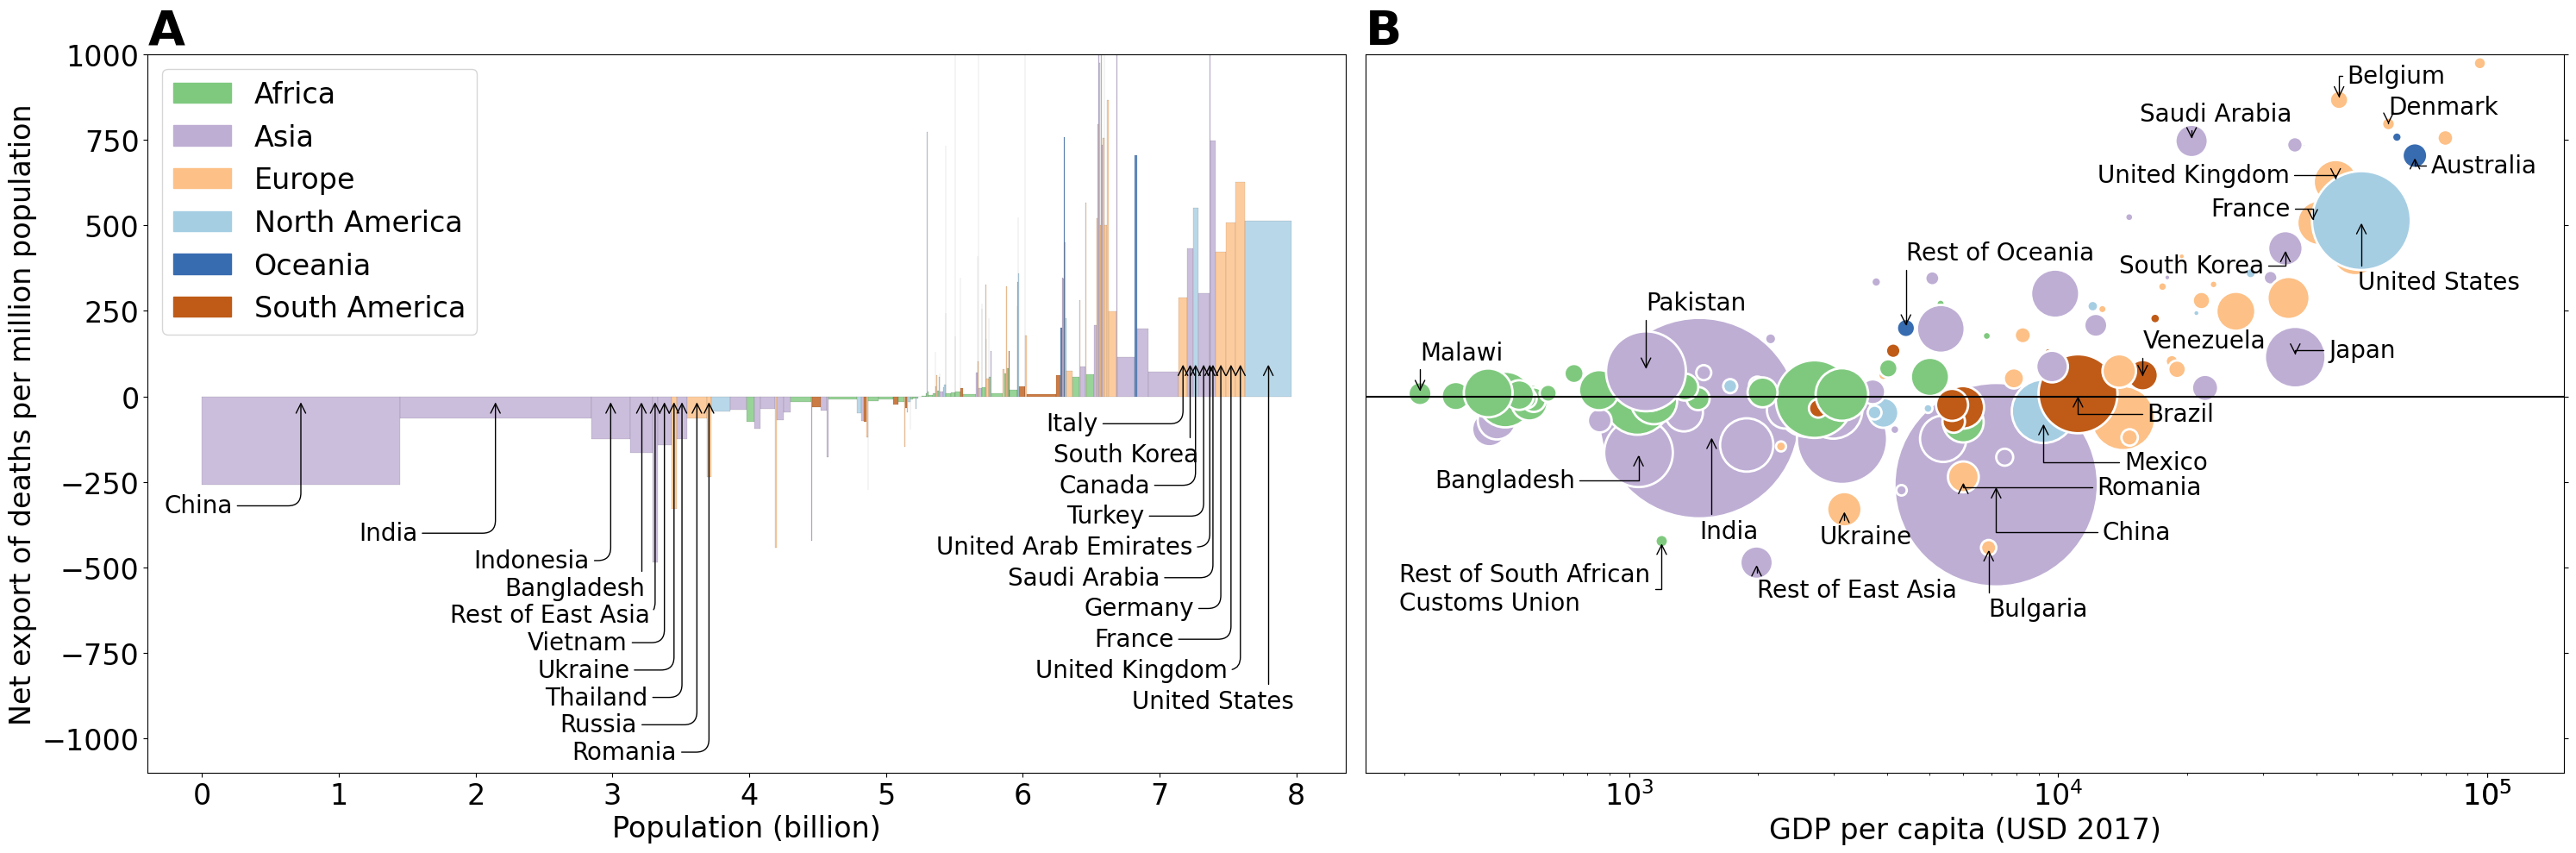

In [18]:
import textwrap
# Create the figure and axes
fig = plt.figure(figsize=(30, 10))
# Plot the bar chart on the first subplot
ax1 = fig.add_subplot(121)
y = df_final_gtap['net_export'] / (df_final_gtap['population'] / 1000000)
w = df_final_gtap['population'] / 1000000000
colors = df_final_gtap['colors']
xticks = []
for n, c in enumerate(w):
    xticks.append(sum(w[:n]) + w[n] / 2)
w_new = [i / max(w) for i in w]
ax1.bar(xticks, height=y, width=w, color=colors, alpha=0.8, linewidth=0.08, edgecolor='black')
ax1.set_ylim(-1100, 1000)
ax1.set_xlabel("Population (billion)", fontsize=24)
# ax1.set_ylabel("Net export of deaths per million population", fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.legend(handles=patches_gtap, fontsize=24)
ax1.set_title(f"{string.ascii_uppercase[0]}", loc='left', pad=-0.5, fontsize=40,fontweight='bold')
plt.ylabel("Net export of deaths per million population",fontsize=24)

# Hide the y ticks
# ax1.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add annotations to the bar chart
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle, angleA=0, angleB=90, rad=15"
)


count1 = -300
for i in country1_list_gtap:
    c_index = list(df_final_gtap['ADM0_A3']).index(i)
    x_loc = sum(w[:c_index]) + (w[c_index] / 2)
    y_loc = -10
    y_text_loc = count1
    if i == 'XEA':
      ax1.annotate(df_final_gtap[df_final_gtap['ADM0_A3'] == i]['NAME'].values[0],
                    xy=(x_loc, y_loc), size=20,
                    arrowprops=arrowprops,
                    xytext=(x_loc - 1.5, y_text_loc-40)
                    )
    else:
      ax1.annotate(df_final_gtap[df_final_gtap['ADM0_A3'] == i]['NAME'].values[0],
                    xy=(x_loc, y_loc), size=20,
                    arrowprops=arrowprops,
                    xytext=(x_loc - 1, y_text_loc-40)
                    )
    count1 -= 80

count2 = -100
for j in country2_list_gtap:
    c_index2 = list(df_final_gtap['ADM0_A3']).index(j)
    x_loc2 = sum(w[:c_index2]) + (w[c_index2] / 2)
    y_loc2 = 100
    y_text_loc2 = count2
    if j =='ARE':
      ax1.annotate(df_final_gtap[df_final_gtap['ADM0_A3'] == j]['NAME'].values[0],
                    xy=(x_loc2, y_loc2), size=20,
                    arrowprops=arrowprops,
                    xytext=(x_loc2 - 2, y_text_loc2)
                    )
    elif j == 'GBR' or j == 'SAU':
      ax1.annotate(df_final_gtap[df_final_gtap['ADM0_A3'] == j]['NAME'].values[0],
                    xy=(x_loc2, y_loc2), size=20,
                    arrowprops=arrowprops,
                    xytext=(x_loc2 - 1.5, y_text_loc2)
                    )
    else:
      ax1.annotate(df_final_gtap[df_final_gtap['ADM0_A3'] == j]['NAME'].values[0][:14],
                    xy=(x_loc2, y_loc2), size=20,
                    arrowprops=arrowprops,
                    xytext=(x_loc2 - 1, y_text_loc2)
                    )
    count2 -= 90




# Plot the bubble chart on the second subplot
ax2 = fig.add_subplot(122)
ax2.set_title(f"{string.ascii_uppercase[1]}", loc='left', pad=-0.5, fontsize=40,fontweight='bold')
scatter = plt.scatter(
    x = df_final_gtap['gdp']/df_final_gtap['population'],
    y = df_final_gtap['net_export']/(df_final_gtap['population']/1000000),
    s=df_final_gtap['population']/50000,
    c=df_final_gtap['CONTINENT'].cat.codes,
    cmap=ListedColormap(["#7fc97f","#beaed4","#fdc086","#a6cee3","#386cb0","#f0027f","#bf5b17"]),
#     alpha=0.3,
    edgecolors="white",
    linewidth=2);

# Hide the y ticks
ax2.set_ylim(-1100, 1000)
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)



# Add titles (main and on axis)
plt.xscale('log')
# legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=continent,
#                     loc="upper left", fontsize=18)
# ax.add_artist(legend1)

# add labels to bubbles that are big enough
arrowprops = dict(
    arrowstyle = "->",
    connectionstyle = "angle, angleA = 0, angleB = 90,\
    rad = 0")

plt.axhline(y = 0.1, color = 'black', linestyle = '-') # label='Line of Zero Net Export of Deaths'
# plt.legend(loc="upper left",fontsize=24)

# CHN
i = 'CHN'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]+5500,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-160),)

i = 'USA'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0][:13],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]-1000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-200),)

i = 'IND'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]+100,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-50),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-350),)

i = 'VEN'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-10),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))+80),)

i = 'AUS'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]+6000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-50),)


i = 'JPN'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]+7000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),)
i = 'KOR'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]-20000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-70),)
i = 'MEX'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0][:13],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-30),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]+5000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-170),)
i = 'PAK'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))+180),)


i = 'BGD'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]-700,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-100),)

i = 'BGR'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-200),)

i = 'ROU'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-10),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]+6300,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-50),)


i = 'BRA'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]+5000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-80),)


i = 'XEA'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-100),)

i = 'SAU'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]-5000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))+60),)

i = 'MWI'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))+100),)

i = 'XSC'
plt.annotate(textwrap.fill(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],width=21),xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]-900,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-200),)


i = 'UKR'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]-400,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))-100),)

i = 'FRA'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]-1500,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]-18000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))+20),)

i = 'DNK'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))+30),)


i = 'BEL'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]+2000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))+50),)

i = 'XOC'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))+200),)

i = 'GBR'
plt.annotate(df_final_gtap[df_final_gtap['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0],
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_gtap[df_final_gtap['ADM0_A3']==i]['gdp'].values[0]/df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]-32000,
           (df_final_gtap[df_final_gtap['ADM0_A3']==i]['net_export'].values[0]/(df_final_gtap[df_final_gtap['ADM0_A3']==i]['population'].values[0]/1000000))),)


matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
ax2.set_xticks([1000,10000,100000,100000]) # Set the x-ticks
plt.xlabel("GDP per capita (USD 2017)",fontsize=24)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
# plt.title("")


plt.tight_layout()
plt.show()
# Save the figure as a PDF with 300 dpi
fig.savefig('First_review_plot/Fig2_GTAP.pdf', dpi=300, bbox_inches='tight')

In [19]:
df_final_gtap.to_csv('First_review_data/Figure2_data.csv')

In [20]:
# @title Read and process file EORA
# population

# We only care about the country sequence
file = open("Data/Total_pop.json", "r")
population2 = file.read()
population2 = json.loads(population2)
Countries = list(population2.keys())

file = open("First_review_data/Total_pop_eora.json", "r")
population_eora = file.read()
population_eora = json.loads(population_eora)
population_eora = {k: population_eora[k] for k in Countries}

# Row sum: total deaths happen in that country
con_total_eora = dict(con_mort_tol_eora.sum(axis = 1))

# Col sum: total deaths caused by that country
con_caused_eora = dict(con_mort_tol_eora.sum(axis = 0))

file = open("Data/total_output_eora.json", "r")
total_output_eora = file.read()
total_output_eora = json.loads(total_output_eora)

file = open("Data/final_demand_eora.json", "r")
final_demand_eora = file.read()
final_demand_eora = json.loads(final_demand_eora)

# EORA is in 1000 USD
for i in total_output_eora:
    total_output_eora[i] = total_output_eora[i] * 1000
    final_demand_eora[i] = final_demand_eora[i] * 1000

gdp_eora = final_demand_eora

# total deaths happen in that country
con_dom_world_eora = {}
for country in con_mort_tol_eora:
    con_dom_world_eora[country] = {}
    con_dom_world_eora[country]['domestic'] = float(con_mort_tol_eora[country][country])
    con_dom_world_eora[country]['world'] = float(con_total_eora[country])
    con_dom_world_eora[country]['OtherPartofWorld'] = con_dom_world_eora[country]['world'] - con_dom_world_eora[country]['domestic']

# total deaths caused by that country
con_cause_dom_world_eora = {}
for country in con_mort_tol_eora:
    con_cause_dom_world_eora[country] = {}
    con_cause_dom_world_eora[country]['domestic'] = float(con_mort_tol_eora[country][country])
    con_cause_dom_world_eora[country]['world'] = float(con_caused_eora[country])
    con_cause_dom_world_eora[country]['OtherPartofWorld'] = con_cause_dom_world_eora[country]['world'] - con_cause_dom_world_eora[country]['domestic']

net_export_death_eora = {}
export_of_death_eora = {}
import_of_death_eora = {}

for country in con_cause_dom_world_eora:
    if country != 'ROW':
        # net export of deaths
        net_export_death_eora[country] = (con_cause_dom_world_eora[country]['OtherPartofWorld'] - con_dom_world_eora[country]['OtherPartofWorld'])
        # total foreign deaths caused by that country's demand
        export_of_death_eora[country] = con_cause_dom_world_eora[country]['OtherPartofWorld']
        # total deaths happen in that country caused by foreign demand
        import_of_death_eora[country] = con_dom_world_eora[country]['OtherPartofWorld']

net_export_death_per_eora = {} # per population

for country in con_cause_dom_world_eora:
    if country != 'ROW':
        net_export_val_eora = (con_cause_dom_world_eora[country]['OtherPartofWorld'] - con_dom_world_eora[country]['OtherPartofWorld'])/(population_eora[country]/10000)
        if net_export_val_eora > 100:
            net_export_death_per_eora[country] = 100
#         elif net_export_val > 100000:
#             net_export_death_per[country] = 100000
        else:
            net_export_death_per_eora[country] = net_export_val_eora

In [21]:
# @title Plot EORA preparation
df_shp = gpd.read_file('Data/10m_cultural/ne_10m_admin_0_countries.shp')
df_shp.loc[df_shp[df_shp['ADM0_A3']=='SDN'].index,'ADM0_A3'] = 'SUD'
df_shp.loc[df_shp[df_shp['ADM0_A3']=='PSX'].index,'ADM0_A3'] = 'PSE'

population_eora.pop('ROW')
gdp_eora.pop('ROW')
# final_demand_eora.pop('ROW')

# Reorder the sequence for the following merging
net_export_death_eora = {k: net_export_death_eora[k] for k in population_eora}
final_demand_eora = {k: final_demand_eora[k] for k in population_eora}
export_of_death_eora = {k: export_of_death_eora[k] for k in population_eora}
import_of_death_eora = {k: import_of_death_eora[k] for k in population_eora}
gdp_eora = {k: gdp_eora[k] for k in population_eora}

df_new_eora = pd.DataFrame({'ADM0_A3': list(net_export_death_eora.keys()),'net_export': list(net_export_death_eora.values()),
                      'population': list(population_eora.values()),'final_demand': list(final_demand_eora.values()),
                      'gdp': list(gdp_eora.values()),
                      'export_of_death': list(export_of_death_eora.values()),'import_of_death': list(import_of_death_eora.values())},)

df_final_eora = pd.merge(df_new_eora,df_shp,how="left",on=["ADM0_A3"])
df_final_eora = df_final_eora[['ADM0_A3','NAME','net_export','export_of_death','import_of_death','population','gdp','final_demand','CONTINENT','geometry']]

# df_final_eora.loc[list(net_export_death_eora.keys()).index('PSE'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='PSX']['CONTINENT'].values[0]
# df_final_eora.loc[list(net_export_death_eora.keys()).index('SUD'),'CONTINENT'] = df_shp[df_shp['ADM0_A3']=='SDN']['CONTINENT'].values[0]

df_final_eora['CONTINENT']=pd.Categorical(df_final_eora['CONTINENT'])
df_final_eora['CONTINENT_code'] = df_final_eora['CONTINENT'].cat.codes
continent = ['Africa','Asia','Europe','North America','Oceania','Seven seas (open ocean)','South America']
continent2 = {'0':'Africa','1':'Asia','2':'Europe','3':'North America','4':'Oceania','5':'Seven seas (open ocean)','6':'South America'}

# Change seven seas to other
df_final_eora['CONTINENT'] = df_final_eora['CONTINENT'].replace(['Seven seas (open ocean)'], 'Other')

df_final_eora['net_export_capita'] = df_final_eora['net_export']/df_final_eora['population']
df_final_eora['final_demand_capita'] = df_final_eora['final_demand']/df_final_eora['population']
df_final_eora['gdp_capita'] = df_final_eora['gdp']/df_final_eora['population']
df_final_eora = df_final_eora[df_final_eora['CONTINENT'] != 'Other']

# After the sorting, we can show more bubbles
df_final_eora.sort_values(by=['net_export'],ascending=True,inplace=True)
df_final_eora.reset_index(drop=True,inplace=True)

# color_map = {'Africa':"#7fc97f",'Asia':"#beaed4",'Europe':"#fdc086",'North America':"#a6cee3",'Oceania':"#386cb0",'South America':"#bf5b17",'Other':"#f0027f"}
color_map = {'Africa':"#7fc97f",'Asia':"#beaed4",'Europe':"#fdc086",'North America':"#a6cee3",'Oceania':"#386cb0",'South America':"#bf5b17"}

df_final_eora['colors']=np.nan
for i in range(len(df_final_eora)):
    df_final_eora.loc[i,'colors'] = color_map[df_final_eora.loc[i,'CONTINENT']]

patches_eora = []
for i in color_map:
    patches_eora.append(mpatches.Patch(color=color_map[i], label=i))

country1_list_eora = list(df_final_eora['ADM0_A3'])[:10]
country2_list_eora = list(df_final_eora['ADM0_A3'])[-10:]

/tmp/ipython-input-3675757438.py:34: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_final_eora['CONTINENT'] = df_final_eora['CONTINENT'].replace(['Seven seas (open ocean)'], 'Other')
/tmp/ipython-input-3675757438.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '#beaed4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final_eora.loc[i,'colors'] = color_map[df_final_eora.loc[i,'CONTINENT']]


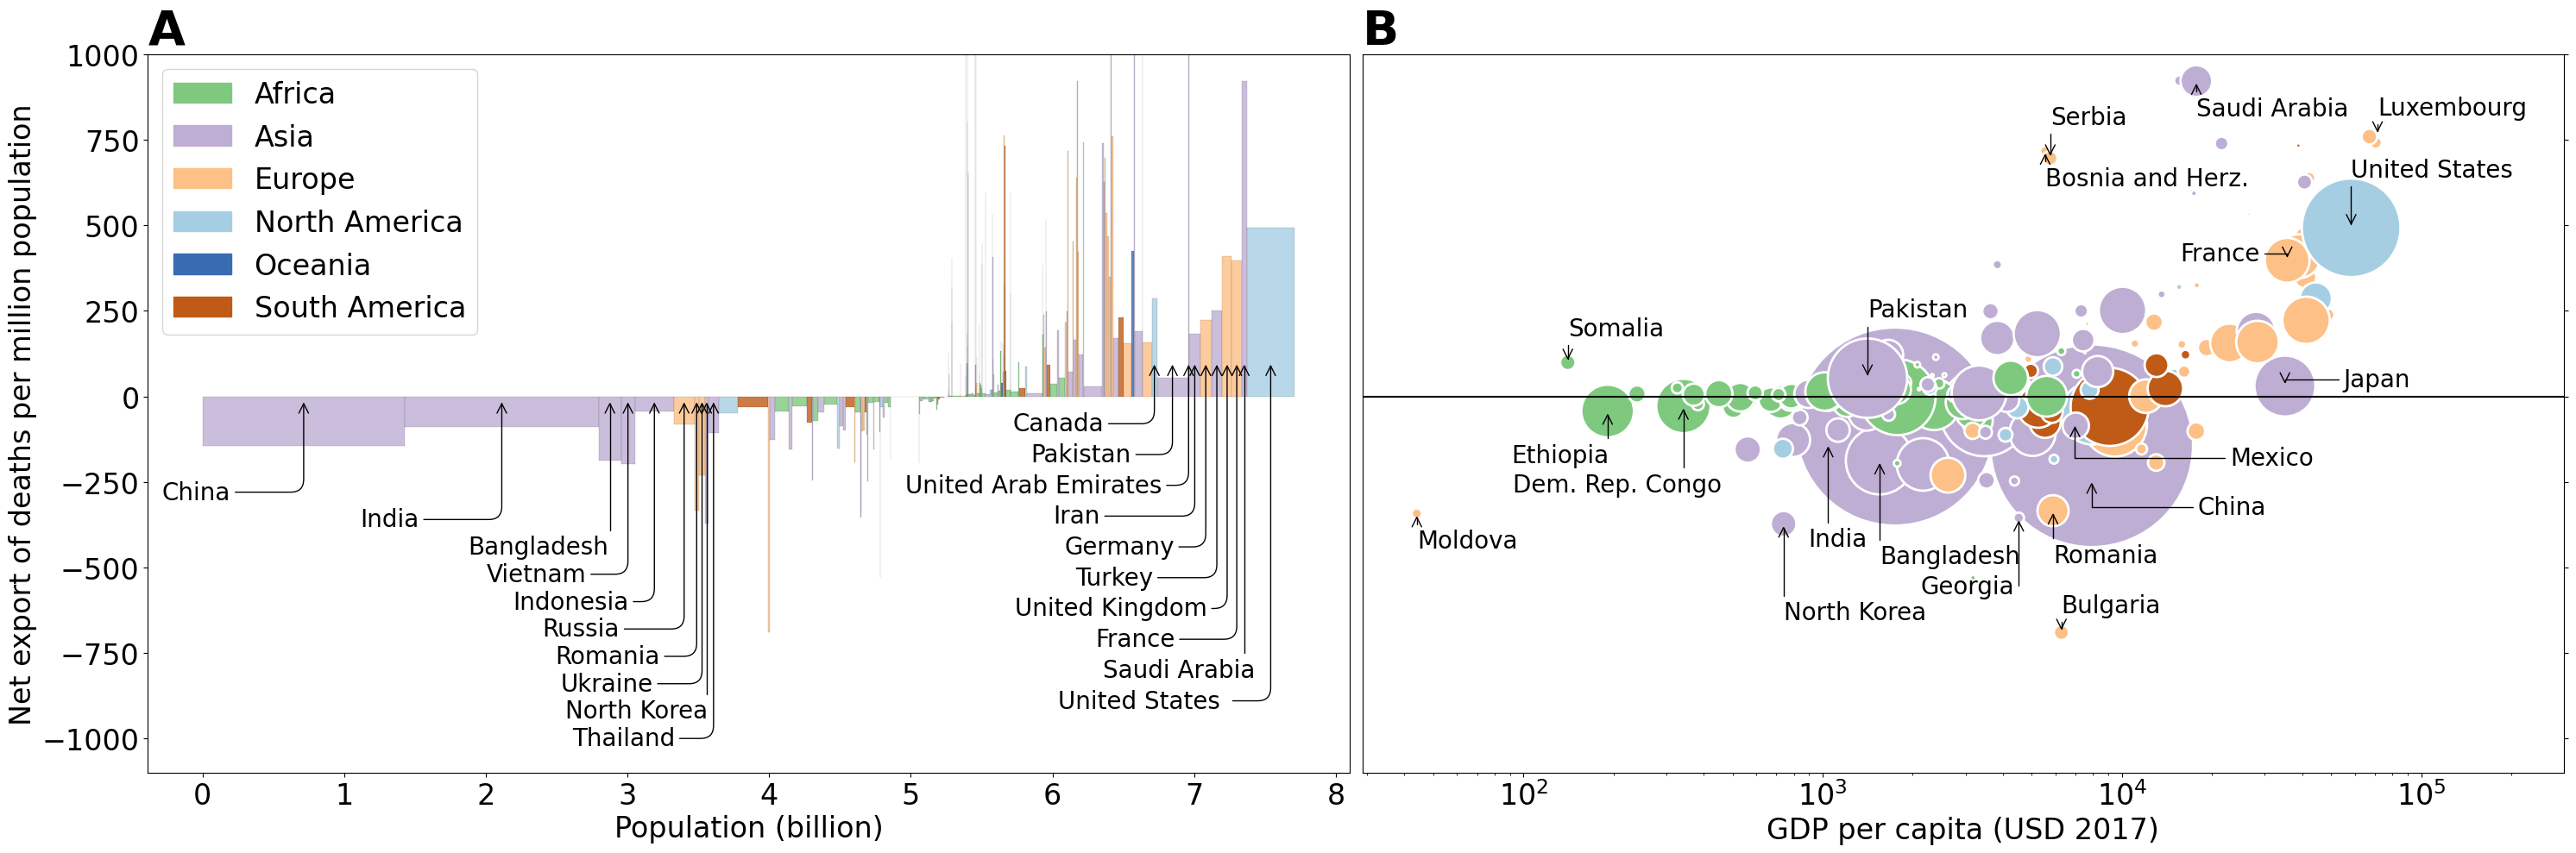

In [22]:
# Create the figure and axes
fig = plt.figure(figsize=(30, 10))
# Plot the bar chart on the first subplot
ax1 = fig.add_subplot(121)
y = df_final_eora['net_export'] / (df_final_eora['population'] / 1000000)
w = df_final_eora['population'] / 1000000000
colors = df_final_eora['colors']
xticks = []
for n, c in enumerate(w):
    xticks.append(sum(w[:n]) + w[n] / 2)
w_new = [i / max(w) for i in w]
ax1.bar(xticks, height=y, width=w, color=colors, alpha=0.8, linewidth=0.1, edgecolor='black')
ax1.set_ylim(-1100, 1000)
ax1.set_xlabel("Population (billion)", fontsize=24)
# ax1.set_ylabel("Net export of deaths per million population", fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.legend(handles=patches_eora, fontsize=24)
ax1.set_title(f"{string.ascii_uppercase[0]}", loc='left', pad=-0.5, fontsize=40,fontweight='bold')


plt.ylim(-1100,1000)
plt.ylabel("Net export of deaths per million population",fontsize=24)
# Add annotations to the bar chart
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle, angleA=0, angleB=90, rad=15"
)

# count1 = -300
# for i in country1_list_eora:
#     c_index = list(df_final_eora['ADM0_A3']).index(i)
#     x_loc = sum(w[:c_index]) + (w[c_index] / 2)
#     y_loc = -10
#     y_text_loc = count1
#     ax1.annotate(df_final_eora[df_final_eora['ADM0_A3'] == i]['NAME'].values[0],
#                   xy=(x_loc, y_loc), size=20,
#                   arrowprops=arrowprops,
#                   xytext=(x_loc - 1, y_text_loc)
#                   )
#     count1 -= 80

# count2 = -100
# for j in country2_list_eora:
#     c_index2 = list(df_final_eora['ADM0_A3']).index(j)
#     x_loc2 = sum(w[:c_index2]) + (w[c_index2] / 2)
#     y_loc2 = 100
#     y_text_loc2 = count2
#     ax1.annotate(df_final_eora[df_final_eora['ADM0_A3'] == j]['NAME'].values[0][:14],
#                   xy=(x_loc2, y_loc2), size=20,
#                   arrowprops=arrowprops,
#                   xytext=(x_loc2 - 1, y_text_loc2)
#                   )
#     count2 -= 90

count1 = -300
for i in country1_list_eora:
    c_index = list(df_final_eora['ADM0_A3']).index(i)
    x_loc = sum(w[:c_index]) + (w[c_index] / 2)
    y_loc = -10
    y_text_loc = count1
    ax1.annotate(df_final_eora[df_final_eora['ADM0_A3'] == i]['NAME'].values[0],
                  xy=(x_loc, y_loc), size=20,
                  arrowprops=arrowprops,
                  xytext=(x_loc - 1, y_text_loc)
                  )
    count1 -= 80

count2 = -100
for j in country2_list_eora:


    c_index2 = list(df_final_eora['ADM0_A3']).index(j)
    x_loc2 = sum(w[:c_index2]) + (w[c_index2] / 2)
    y_loc2 = 100
    y_text_loc2 = count2
    if j == 'GBR' or j == 'USA':
      ax1.annotate(df_final_eora[df_final_eora['ADM0_A3'] == j]['NAME'].values[0][:14],
                  xy=(x_loc2, y_loc2), size=20,
                  arrowprops=arrowprops,
                  xytext=(x_loc2 - 1.5, y_text_loc2)
                  )

    elif j =='ARE':
      ax1.annotate(df_final_eora[df_final_eora['ADM0_A3'] == j]['NAME'].values[0],
                  xy=(x_loc2, y_loc2), size=20,
                  arrowprops=arrowprops,
                  xytext=(x_loc2 - 2, y_text_loc2)
                  )
    else:
      ax1.annotate(df_final_eora[df_final_eora['ADM0_A3'] == j]['NAME'].values[0],
                  xy=(x_loc2, y_loc2), size=20,
                  arrowprops=arrowprops,
                  xytext=(x_loc2 - 1, y_text_loc2)
                  )
    count2 -= 90




# Plot the CIRCLE on the second subplot
ax2 = fig.add_subplot(122)
ax2.set_title(f"{string.ascii_uppercase[1]}", loc='left', pad=-0.5, fontsize=40,fontweight='bold')
scatter = plt.scatter(
    x = df_final_eora['gdp']/df_final_eora['population'],
    y = df_final_eora['net_export']/(df_final_eora['population']/1000000),
    s=df_final_eora['population']/50000,
    c=df_final_eora['CONTINENT'].cat.codes,
    cmap=ListedColormap(["#7fc97f","#beaed4","#fdc086","#a6cee3","#386cb0","#f0027f","#bf5b17"]),
#     alpha=0.3,
    edgecolors="white",
    linewidth=2);

# Hide the y ticks
ax2.set_ylim(-1100, 1000)
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add titles (main and on axis)
plt.xscale('log')
# legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=continent,
#                     loc="upper left", fontsize=18)
# ax.add_artist(legend1)

# add labels to bubbles that are big enough
arrowprops = dict(
    arrowstyle = "->",
    connectionstyle = "angle, angleA = 0, angleB = 90,\
    rad = 0")

plt.axhline(y = 0.1, color = 'black', linestyle = '-') # label='Line of Zero Net Export of Deaths'
# plt.legend(loc="upper left",fontsize=24)

# CHN
i = 'CHN'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-100),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]+10000,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-200),)

i = 'USA'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0][:13],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))+150),)

i = 'IND'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]-700,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-50),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]-850,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-350),)

# i = 'VEN'
# plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
#            (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
#              arrowprops = arrowprops,
#              xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]-5,
#            (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))+80),)

i = 'SOM'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))+80),)

i = 'ETH'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]-100,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-150),)

i = 'COD'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]-250,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-250),)


i = 'JPN'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]+20000,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),)
# i = 'KOR'
# plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
#            (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
#              arrowprops = arrowprops,
#              xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]+15000,
#            (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-150),)
i = 'MEX'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0][:13],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]-1000,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-30),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]+15000,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-150),)
i = 'PAK'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))+180),)

i = 'PRK'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-280),)

i = 'BGD'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-300),)

i = 'BGR'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))+60),)
i = 'ROU'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-150),)
# i = 'BRA'
# plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]+2400,
#            (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
#              arrowprops = arrowprops,
#              xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]+10000,
#            (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-20),)

i = 'GEO'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]-2400,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-220),)


i = 'SAU'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-100),)



i = 'FRA'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]-20000,
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),)

i = 'MDA'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-100),)

i = 'BIH'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))-100),)
i = 'SRB'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))+100),)


i = 'LUX'
plt.annotate(df_final_eora[df_final_eora['ADM0_A3']==i]['NAME'].values[0],xy=(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))),size=20,
             arrowprops = arrowprops,
             xytext =(df_final_eora[df_final_eora['ADM0_A3']==i]['gdp'].values[0]/df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0],
           (df_final_eora[df_final_eora['ADM0_A3']==i]['net_export'].values[0]/(df_final_eora[df_final_eora['ADM0_A3']==i]['population'].values[0]/1000000))+60),)



matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
# plt.xlabel("log(Final demand per capita(dollars))",fontsize=24)
# ax2.set_xticks(xticks_expanded) # Set the x-ticks
# ax2.set_xticklabels(xticks_expanded,fontsize=24) # Set the labels for the x-ticks
# ax2.set_xticks([1000,10000,100000]) # Set the x-ticks
# ax2.set_xticklabels([100,500,1000,5000,10000,100000],fontsize=24) # Set the labels for the x-ticks
plt.xlabel("GDP per capita (USD 2017)",fontsize=24)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
# plt.title("")


plt.tight_layout()
plt.show()
# Save the figure as a PDF with 300 dpi
fig.savefig('First_review_plot/Fig2_EORA.pdf', dpi=300, bbox_inches='tight')


In [23]:
df_final_gtap.to_csv('First_review_data/Figure2_data_suppl.csv')

In [24]:
# economic demand for exports was responsible for this percent of total trade-related morality
dictsum(export_of_death_gtap)/dictsum(con_caused_gtap),dictsum(export_of_death_eora)/dictsum(con_caused_eora)

(np.float64(0.4827709342486571), np.float64(0.40366391835032306))

In [25]:
# the countries who occur more deaths in other countries by their own consumption
count = 0
for i in con_caused_eora:
  death_in_other = con_caused_eora[i] - con_mort_tol_eora[i][i]
  death_in_own = con_mort_tol_eora[i][i]
  if death_in_other > death_in_own:
    count+=1
print(count/len(con_caused_eora))

count = 0
for i in con_caused_gtap:
  death_in_other = con_caused_gtap[i] - con_mort_tol_gtap[i][i]
  death_in_own = con_mort_tol_gtap[i][i]
  if death_in_other > death_in_own:
    count+=1
print(count/len(con_caused_gtap))

0.776595744680851
0.8297872340425532


In [26]:
ratio_1 = {}
for i in con_caused_eora:
  death_in_other = con_caused_eora[i] - con_mort_tol_eora[i][i]
  death_in_own = con_mort_tol_eora[i][i]
  if death_in_own > death_in_other * 3:
    ratio_1[i] =  death_in_own/death_in_other
ratio_1

{'AGO': np.float64(3.3929551404776412),
 'BRA': np.float64(5.135094370982286),
 'CHN': np.float64(7.9588093945431755),
 'COL': np.float64(3.0324207916251726),
 'HTI': np.float64(5.844536173954704),
 'IDN': np.float64(7.950988842026529),
 'PER': np.float64(3.656822622906863),
 'ZAF': np.float64(3.3348998139123927)}

In [27]:
ratio_1 = {}
for i in con_caused_gtap:
  death_in_other = con_caused_gtap[i] - con_mort_tol_gtap[i][i]
  death_in_own = con_mort_tol_gtap[i][i]
  if death_in_own > death_in_other * 2:
    ratio_1[i] =  death_in_own/death_in_other
ratio_1

{'BRA': np.float64(3.050040346341889),
 'CHN': np.float64(6.513722221182922),
 'COL': np.float64(2.8960193236212737),
 'IDN': np.float64(4.172805317480365),
 'IND': np.float64(2.637131306933888),
 'PER': np.float64(2.6676305959882316),
 'PHL': np.float64(2.0159321564166626)}

In [28]:
df_final_eora.sort_values(by='net_export', ascending=True)[:6]

,ADM0_A3,NAME,net_export,export_of_death,import_of_death,population,gdp,final_demand,CONTINENT,geometry,CONTINENT_code,net_export_capita,final_demand_capita,gdp_capita,colors
0,CHN,China,-206201.472424,94258.802507,300460.274931,1.429385e+09,1.132871e+13,1.132871e+13,Asia,"MULTIPOLYGON (((78.91595 33.38766, 78.82426 33...",1,-0.000144,7925.580878,7925.580878,#beaed4
1,IND,India,-120350.817048,87179.987008,207530.804056,1.366845e+09,2.382566e+12,2.382566e+12,Asia,"MULTIPOLYGON (((77.80035 35.49541, 77.81533 35...",1,-0.000088,1743.113709,1743.113709,#beaed4
2,BGD,Bangladesh,-29828.280463,10503.514376,40331.794840,1.588812e+08,2.462198e+11,2.462198e+11,Asia,"MULTIPOLYGON (((92.57588 21.97757, 92.59024 21...",1,-0.000188,1549.709701,1549.709701,#beaed4
3,VNM,Vietnam,-19130.863543,8013.229086,27144.092629,9.627147e+07,2.083696e+11,2.083696e+11,Asia,"MULTIPOLYGON (((107.52039 14.70458, 107.52225 ...",1,-0.000199,2164.395796,2164.395796,#beaed4
4,IDN,Indonesia,-12340.765989,11125.784081,23466.550070,2.766634e+08,9.607538e+11,9.607538e+11,Asia,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",1,-0.000045,3472.645480,3472.645480,#beaed4
5,RUS,Russia,-11754.283712,20028.706028,31782.989740,1.434064e+08,1.359113e+12,1.359113e+12,Europe,"MULTIPOLYGON (((87.81632 49.16584, 87.71638 49...",2,-0.000082,9477.352998,9477.352998,#fdc086


In [29]:
df_final_gtap.sort_values(by='net_export', ascending=True)[:5]

,ADM0_A3,NAME,net_export,export_of_death,import_of_death,population,gdp,final_demand,CONTINENT,CONTINENT_code,net_export_capita,final_demand_capita,gdp_capita,colors
0,CHN,China,-372637.036475,89110.649177,461747.685652,1.443900e+09,10351105000000,4.846769e+12,Asia,1,-0.000258,3356.720934,7168.852220,#beaed4
1,IND,India,-88873.764789,97803.615283,186677.380072,1.401273e+09,2042442000000,1.421773e+12,Asia,1,-0.000063,1014.629470,1457.561884,#beaed4
2,IDN,Indonesia,-35205.560218,16373.952183,51579.512400,2.840163e+08,890481000000,5.747587e+11,Asia,1,-0.000124,2023.682266,3135.316740,#beaed4
3,BGD,Bangladesh,-27039.286643,12360.880100,39400.166743,1.643525e+08,172885000000,1.344331e+11,Asia,1,-0.000165,817.955857,1051.915559,#beaed4
4,XEA,Rest of East Asia,-17870.149316,1871.077241,19741.226557,3.678637e+07,72914000000,2.966040e+10,Asia,1,-0.000486,806.287670,1982.092884,#beaed4


In [30]:
df_final_gtap.sort_values(by='net_export_capita', ascending=False)[:1]

,ADM0_A3,NAME,net_export,export_of_death,import_of_death,population,gdp,final_demand,CONTINENT,CONTINENT_code,net_export_capita,final_demand_capita,gdp_capita,colors
132,ARE,United Arab Emirates,25830.592047,27251.187163,1420.595116,9.015692e+06,399453000000,2.923627e+11,Asia,1,0.002865,32428.201891,44306.417788,#beaed4


In [31]:
df_final_eora.sort_values(by='net_export_capita', ascending=False)[:1]

,ADM0_A3,NAME,net_export,export_of_death,import_of_death,population,gdp,final_demand,CONTINENT,geometry,CONTINENT_code,net_export_capita,final_demand_capita,gdp_capita,colors
78,SMR,San Marino,43.943573,45.434949,1.491376,6491.896674,8.921205e+08,8.921205e+08,Europe,"POLYGON ((12.42945 43.89206, 12.39958 43.90322...",2,0.006769,137420.62416,137420.62416,#fdc086


In [32]:
df_final_eora[df_final_eora['CONTINENT']=='North America']['net_export'].sum(),df_final_gtap[df_final_gtap['CONTINENT']=='North America']['net_export'].sum()

(np.float64(169261.73326065674), np.float64(193908.91270940483))

In [33]:
df_final_eora[df_final_eora['CONTINENT']=='Europe']['net_export'].sum(),df_final_gtap[df_final_gtap['CONTINENT']=='Europe']['net_export'].sum()

(np.float64(100011.14856383654), np.float64(172885.02581102715))

In [34]:
df_final_eora[df_final_eora['CONTINENT']=='Asia']['net_export'].sum(),df_final_gtap[df_final_gtap['CONTINENT']=='Asia']['net_export'].sum()

(np.float64(-253535.582513856), np.float64(-391775.34978233493))

In [35]:
df_final_eora[df_final_eora['CONTINENT']=='Africa']['net_export'].sum(),df_final_gtap[df_final_gtap['CONTINENT']=='Africa']['net_export'].sum()

(np.float64(-8212.337449983821), np.float64(1559.9297202920802))

In [36]:
df_final_eora[df_final_eora['CONTINENT']=='South America']['net_export'].sum(),df_final_gtap[df_final_gtap['CONTINENT']=='South America']['net_export'].sum()

(np.float64(557.6654223859341), np.float64(2920.1898108645883))

In [37]:
df_final_eora[df_final_eora['CONTINENT']=='Oceania']['net_export'].sum(),df_final_gtap[df_final_gtap['CONTINENT']=='Oceania']['net_export'].sum()

(np.float64(10909.702314738068), np.float64(19868.20063383399))

In [38]:
for continent in list(df_final_gtap['CONTINENT'].unique()):
    df_continent = df_final_gtap[df_final_gtap['CONTINENT'] == continent]
    total_number = df_continent.population.sum()
    negative = df_continent[df_continent['net_export'] < 0].population.sum()
    positive = df_continent[df_continent['net_export'] >= 0].population.sum()
    print(continent,'negative',negative/total_number,'positive',positive/total_number)

Asia negative 0.8380163056113835 positive 0.16198369438861662
Europe negative 0.31129717865876666 positive 0.6887028213412335
North America negative 0.3213648251897442 positive 0.6786351748102558
Africa negative 0.5421593713706446 positive 0.45784062862935554
South America negative 0.2815888904397447 positive 0.7184111095602552
Oceania negative 0.0 positive 1.0


In [39]:
df_final_gtap[df_final_gtap['net_export'] < 0].population.sum() / df_final_gtap.population.sum()

np.float64(0.6607236282713083)

/tmp/ipython-input-524647640.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_gdp_minus_10k'] = np.log10(df_filtered['gdp_capita'] - 10000)
/tmp/ipython-input-524647640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['net_export_permillion'] = df_final_gtap['net_export']/ (df_final_gtap['population'] / 1000000)


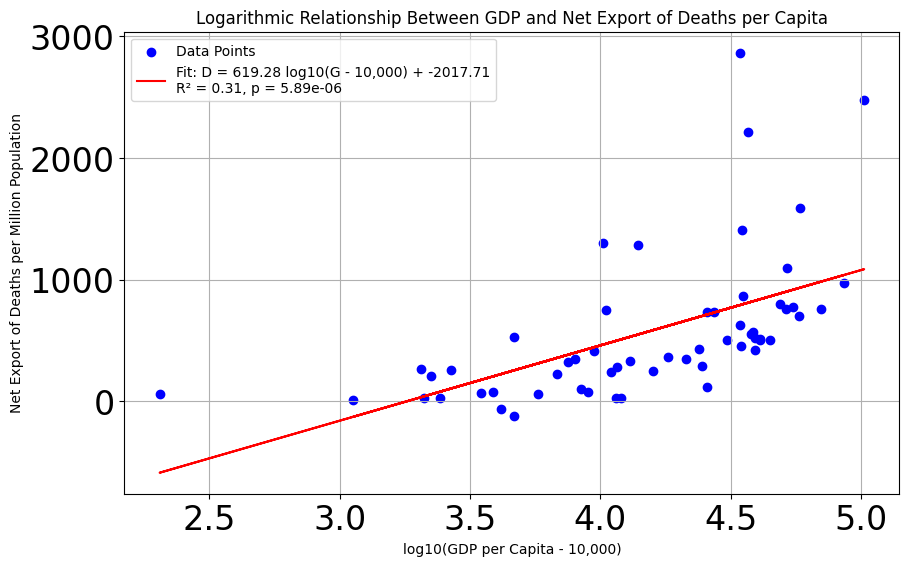

Linear regression equation: D = 619.28 * log10(G - 10,000) + -2017.71
Coefficient of determination (R²): 0.31
t-test significance (p-value): 5.89e-06


In [40]:
from scipy.stats import linregress
# Filter nations with per-capita GDP greater than 10,000 USD-2017
df_filtered = df_final_gtap[df_final_gtap['gdp_capita']>=10000]
# Transform GDP data
df_filtered['log_gdp_minus_10k'] = np.log10(df_filtered['gdp_capita'] - 10000)

df_filtered['net_export_permillion'] = df_final_gtap['net_export']/ (df_final_gtap['population'] / 1000000)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(df_filtered['log_gdp_minus_10k'], df_filtered['net_export_permillion'])

# Calculate R-squared
r_squared = r_value**2

# Plot the data and fit
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['log_gdp_minus_10k'], df_filtered['net_export_permillion'], label='Data Points', color='blue')
plt.plot(df_filtered['log_gdp_minus_10k'], intercept + slope * df_filtered['log_gdp_minus_10k'], 'r', label=f'Fit: D = {slope:.2f} log10(G - 10,000) + {intercept:.2f}\nR² = {r_squared:.2f}, p = {p_value:.2e}')
plt.xlabel('log10(GDP per Capita - 10,000)')
plt.ylabel('Net Export of Deaths per Million Population')
plt.title('Logarithmic Relationship Between GDP and Net Export of Deaths per Capita')
plt.legend()
plt.grid(True)
plt.show()

# Print regression results
print(f"Linear regression equation: D = {slope:.2f} * log10(G - 10,000) + {intercept:.2f}")
print(f"Coefficient of determination (R²): {r_squared:.2f}")
print(f"t-test significance (p-value): {p_value:.2e}")

In [41]:
df_final_gtap.sort_values(by='net_export_capita', ascending=False)[:5]

,ADM0_A3,NAME,net_export,export_of_death,import_of_death,population,gdp,final_demand,CONTINENT,CONTINENT_code,net_export_capita,final_demand_capita,gdp_capita,colors
132,ARE,United Arab Emirates,25830.592047,27251.187163,1420.595116,9.015692e+06,399453000000,2.923627e+11,Asia,1,0.002865,32428.201891,44306.417788,#beaed4
94,LUX,Luxembourg,1426.146354,1480.060735,53.914380,5.758017e+05,64874000000,5.873897e+10,Europe,2,0.002477,102012.502086,112667.263444,#fdc086
123,HKG,Hong Kong,13742.476974,16570.532170,2828.055196,6.213623e+06,291229000000,2.181655e+11,Asia,1,0.002212,35110.836405,46869.434612,#beaed4
119,SGP,Singapore,7129.157017,8811.650966,1682.493949,4.496501e+06,306344000000,1.675601e+11,Asia,1,0.001585,37264.547809,68129.414488,#beaed4
113,KWT,Kuwait,5127.796421,5367.691065,239.894644,3.632699e+06,163612000000,8.506135e+10,Asia,1,0.001412,23415.468759,45038.689868,#beaed4


In [42]:
0.002865 * 1000000

2865.0

In [43]:
df_final_eora.sort_values(by='net_export_capita', ascending=False)[:15]

,ADM0_A3,NAME,net_export,export_of_death,import_of_death,population,gdp,final_demand,CONTINENT,geometry,CONTINENT_code,net_export_capita,final_demand_capita,gdp_capita,colors
78,SMR,San Marino,43.943573,45.434949,1.491376,6.491897e+03,8.921205e+08,8.921205e+08,Europe,"POLYGON ((12.42945 43.89206, 12.39958 43.90322...",2,0.006769,137420.624160,137420.624160,#fdc086
93,LIE,Liechtenstein,114.558834,117.399330,2.840496,2.532226e+04,4.983257e+09,4.983257e+09,Europe,"POLYGON ((9.52115 47.2628, 9.53025 47.25365, 9...",2,0.004524,196793.524678,196793.524678,#fdc086
172,KWT,Kuwait,9999.779185,10192.249486,192.470300,3.441876e+06,1.017357e+11,1.017357e+11,Asia,"MULTIPOLYGON (((47.94801 29.99405, 47.95509 29...",1,0.002905,29558.210266,29558.210266,#beaed4
90,MCO,Monaco,99.254946,121.838545,22.583599,5.781547e+04,6.427272e+09,6.427272e+09,Europe,"POLYGON ((7.43745 43.74336, 7.43285 43.73985, ...",2,0.001717,111168.712985,111168.712985,#fdc086
176,ARE,United Arab Emirates,13160.945919,14013.579161,852.633242,8.775765e+06,2.667452e+11,2.667452e+11,Asia,"MULTIPOLYGON (((56.27906 25.62745, 56.3003 25....",1,0.001500,30395.666677,30395.666677,#beaed4
164,SGP,Singapore,6499.453722,8024.372468,1524.918746,4.377950e+06,2.337253e+11,2.337253e+11,Asia,"POLYGON ((103.96079 1.3911, 103.98569 1.38544,...",1,0.001485,53386.931524,53386.931524,#beaed4
170,HKG,Hong Kong,9792.799583,14474.949169,4682.149586,7.711533e+06,3.194943e+11,3.194943e+11,Asia,"MULTIPOLYGON (((114.22983 22.55581, 114.23471 ...",1,0.001270,41430.710691,41430.710691,#beaed4
74,ABW,Aruba,33.027739,35.666564,2.638826,3.138320e+04,2.421791e+09,2.421791e+09,North America,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",3,0.001052,77168.378467,77168.378467,#a6cee3
153,OMN,Oman,3715.931303,4261.266607,545.335305,4.025771e+06,6.271514e+10,6.271514e+10,Asia,"MULTIPOLYGON (((56.26062 25.33108, 56.29069 25...",1,0.000923,15578.415827,15578.415827,#beaed4
182,SAU,Saudi Arabia,32274.329786,35637.423426,3363.093640,3.500801e+07,6.207144e+11,6.207144e+11,Asia,"MULTIPOLYGON (((50.80787 24.74665, 50.88101 24...",1,0.000922,17730.640405,17730.640405,#beaed4
